# Reinforcement Learning: Framework
* Markov Decision Process (MDP): $(S,A,P,R,\gamma)$
* State Transition and Reward Model: $P(S_{t+1},R_{t+1}|S_t,A_t)$
* State Value Function: V(S)
* Action value Function: Q(S,A)
* Goal : Find optimal policy $\pi_*$ that maximizes total expected reward.


# Reinforcement Learning: Algorithms
* __Model-Based Learning (Dynamic Programming)__
    * Policy Iteration
    * Value Iteration
    <br>**(Requires a know transition and reward model.)**
* __Model-Free Learning__ 
    * Monte Carlo Methods
    * Temporal-Difference Learning
    <br>**(They sample the environment by carrying exploration actions and use the experience gained to directly estimate value functions)**
    

# Discrete vs. Continuous Spaces
* States, Action: finite!!
* If action and state space is discrete than we can map them in Q table and then can have optimal policy.

$V: S \to R$ (STATE VALUE Function)
<br>$Q: S \times A \to R$(Action value function)

For example in Q-Learning when we find maxQ\[state\] we assume the action space to be discrete.

In real world we don't have discrete world like grid space, it's continuous.

### Dealing with Continuous Spaces
1. Discretization
2. Function Approximation


* **Discretization**: Is basically converting a continuous space into a discrete one.

* __Non-Uniform Discretization__: Depends on the environment, basic idea is to recognize area with more precision where attention is required.
* And we don't want to have smaller grid through out the space because, it will increase the number state spaces and hence computation.
* __Read about BINARY SPACE PARTITIONING OR QUAD TREES__

# Discretization
***

In this notebook, we will deal with continuous state and action spaces by discretizing them. This will enable us to apply reinforcement learning algorithms that ae only desingned to work with discrete spaces.

### 1. Import the Necessary Packages

In [ ]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options 
%matplotlib inline 
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size = (1400, 900))

is_python = 'inline' in plt.get_backend()
if is_python:
    from IPython import display

plt.ion()

## 2. Specify the Environment, and Explore the State and Action Spaces
We'll use OpenAI Gym environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks. Let's use an environment that has a continuous state space, but a discrete action space. 

In [ ]:
# Create an environment and set random seed
env = gym.make('MountainCar-v0')
env.seed(505);

In [ ]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state,reward,done,_ = env.step(action)
    if done:
        print('Score: ', t+1)
        break

env.close()

In [ ]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("-low:", env.observation_space.low)
print("-high:",env.observation_space.high)

In [ ]:
#Generate some samples from the state space
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))


In [ ]:
#Explore the action space
print("Action space:", env.action_space)

#Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

## 3. Discrete the State Space with a Uniform Grid

We will discretize the space using a uniformly-spaced grid. Implemented the following function to create such a grid, given the lower bounds(`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It should return the split points for each dimension, which will be 1 less than the number of bins.

For instance, if `low = [-1.0, 5.0]`,`high = [1.0,5.0]` and `bins = (10,10)`, then your function should return following list of 2 NumPy arrays:

```
[array([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]),
 array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])]
```

Note that the ends of `low` and `high` are **not** inculded in these split points. It is assumed that any value below the lowest split maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along the dimension.

In [53]:
#np.set_printoptions(precision=0, linewidth=120)
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})
(np.arange(-1.0,1.0,0.2))

array([-1.0, -0.8, -0.6, -0.4, -0.2, -0.0, 0.2, 0.4, 0.6, 0.8])

In [11]:
import numpy as np
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    ls = []
    low_x,low_y=low
    high_x,high_y = high
    diff_x = (high_x-low_x)/bins[0]
    diff_y = (high_y-low_y)/bins[1]
    ls.append(np.arange(low_x,high_x,diff_x)[1:])
    ls.append(np.arange(low_y,high_y,diff_y)[1:])
    return ls

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})
low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

[array([-0.8, -0.6, -0.4, -0.2, -0.0, 0.2, 0.4, 0.6, 0.8]),
 array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])]

In [12]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    x = np.digitize(sample[0],grid[0])
    y = np.digitize(sample[1],grid[1])
    return x,y


# Test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ -0.5 ,  -0.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep = "\n")


Samples:
array([[-1.0, -5.0],
       [-0.8, -4.1],
       [-0.8, -4.0],
       [-0.5, 0.0],
       [0.2, -1.9],
       [0.8, 4.0],
       [0.8, 4.1],
       [-0.5, -0.0]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [6, 3],
       [9, 9],
       [9, 9],
       [2, 5]])


## 4. Visualization
It might be helpful to visualize the original and discretized samples to get a sense of how much error we are introducing.

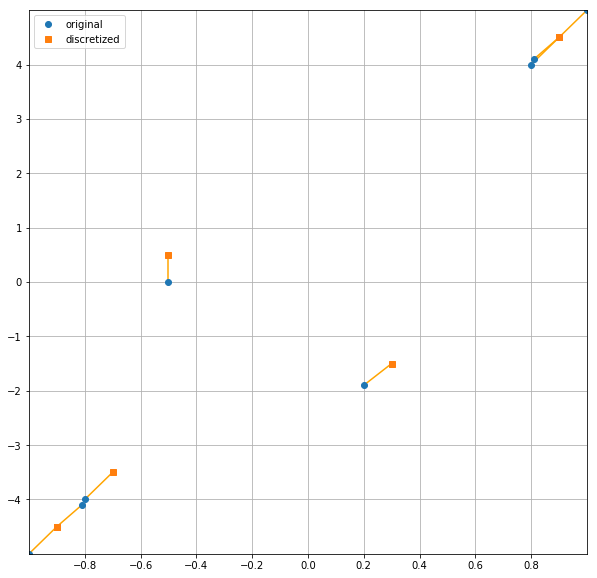

In [275]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None,high=None):
    """Visualize original and discretized samples on a given  2-dimensional grid."""
    
    fig,ax = plt.subplots(figsize=(10,10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]
    
    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

import matplotlib.pyplot as plt    
visualize_samples(samples, discretized_samples, grid, low, high)

In [ ]:
# Create a grid discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10,10))
state_grid

In [ ]:
#Obtain some samples from the space, discretize them,and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position');plt.ylabel('velocity');

You might notice that if we have enough bins, the discretization doesn't introduce too much error into our representation. So we may be able to now apply reinforcement learning algorithm(like Q Learning) that operates on discrete spaces. Given it a shot to see how well it works!

## 5. Q-Learning 
Provided below is a simple Q-Learning agent. Implement the `preprocess_state()` method to convert each continuous state sample to its corresponding discretized representation.

In [ ]:
def QLearningAgent():
    """Q-Learning agent that can act on a continuous state space by discretizing it"""
    
    def __init__(self,env,state_grid,alpha=0.02,gamma=0.99,
                epsilon=1.0,epsilon_decay_rate = 0.9995, min_epsilon=.01,seed=505):
        """Initialize variables, create grid for discretization."""
        ## Environment info
        self.env = env
        self.state_grid = state_grid
        ## FOr n dimensional state space
        self.state_size = tuple(len(splits)+1 for splits in self.state_grid)
        self.action_size = self.env.action_space.n # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:",self.state_size)
        
        ## Learning parameters
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.epsilon = self.initial_epsilon=epsilon # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly it will decay
        self.min_epsilon= min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)
        
    def preprocess_state(self,state):
        """Map a continuous state to its discretized representation."""
        discretize_state = tuple(discretize(state,self.state_grid))
        return discretize_state
    
    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon,self.min_epsilon)
        
        # Decide inital action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon=epsilon if epsilon is not None else self.initial_epsilon
        
    def act(self,state,reward=None,done=None,mode="train"):
        """Pick next action and update internal Q table (when mode != 'test')"""
        state = self.preprocess_state(state)
        if mode =='test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state,action) pair with current state,reward
            self.q_table[self.last_state+(self.last_action,)] += self.alpha* \
            (reward+ self.gamma*max(self.q_table[state])-self.q_table[self.last_state+(self.last_action,)])
            
            
            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0,1)< self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0,self.action_size)
            else:
                # Pick the best action from Q table 
                action = np.argmax(self.q_table[state])
        
        # Roll over current state, action for next stepa
        self.last_state = state
        self.last_action =action
        return action
    
    
q_agent = QLearningAgent(env, state_grid)
            
        
        
        

Let's also define a convenience function to run an agent on a given environment. When calling this function, we can pass in `mode = 'test'` to tell the agent not to learn.

In [ ]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done= False
        
        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)
            
        # Save final score
        scores.append(total_reward)
        
        #Print episode stats
        if mode == 'train':
            if len(scores)>100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
                    
            if i_episode % 100 ==0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode,num_episodes,max_avg_score), end="")
                sys.stdout.flush()
                
    return scores
scores = run(q_agent,env)

The best way to analyze if our agent was learning the task is to plot the scores. It should generally increase as the agent goes through more episodes.

In [ ]:
# Plot scores obtained per episode 
plt.plot(scores); plt.title("Scores");

If the scores are noisy, it might be difficult to tell whether our agent is actually learning. To find the underlying trend, we may want to plot a rolling mean of the scores. Let's write a convenience function to plot both row scores as well as a rolling mean.

In [ ]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores);plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean
rolling_mean = plot_scores(scores)

We should observe the mean of episode scores go up over time. Next, we can freeze learning and run the agent in test mode to see how well it performs.

In [ ]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. scores = {}".format(len(test_scores),np.mean(test_scores)))
_ = plot_scores(test_scores, rolling_window = 10)

It's also interesting to look at the final Q-table that is learned  by the agent. Note that the Q-table is of size $M\times N \times A$, where $(M,N)$ is the size of the state space, and $A$ is the size of the action space. We are intrested in the maximum Q-value for each state, and corresponding (best) action associated with that value.

In [ ]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table,axis=2)  # max Q-value for each state
    q_actions = np.argmax(q_table,axis=2) # max action for each state
    
    fig,ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(q_image, cmap = 'jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x,y,q_actions[x,y],color="white",
                   horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    
plot_q_table(q_agent.q_table)

# 7. Watch a Smart Agent

In [ ]:
state = env.reset()
score = 0
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = q_agent_new.act(state, mode='test')
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward,done,_ = env.step(action)
    score += reward
    if done:
        print("Score: ",score)
        break
env.close()

# Tile Coding 

* Here the underlying state space is continuous and two dimensional.
* __We overlay multiple grids or tiling on top of the space, each slightly offset from each other. Now any state space can be coarsely identified by the tiles that it activates.__
* If we assign a bit to each tile, then we can represent our new discretised state as a bit vector, with ones for the tiles that get activated, zeros elswhere.

* **But the genius lies in how the state value function is computed using the scheme.**
    * Instead of storing a separate value for each state V of S, It is defined in terms of the bit vector for that state and a weight for each tile. 
    * The tile coding algorithm in turns updates these weights iteratively.
    * This ensures nearby locations that share tile also share some component of state value, effectively smoothing the learned value function.

<img src = "images\a13.png">


### Drawbacks
* Manually select the tile sizes, there offsets, number of tilings, ahead of time.

## Adaptive Tile Coding
* A more flexible approach is adaptive tile coding, which starts with fairly large tile and divides each tile into two whenever appropriate.
    * Well, we can use a hero stick for that.
    * Basically we want to split the state space when we __realize that we are no longer learning much with current representation__.(That is, when our value function isn't changing.) We can stop when we reach a upper limit to the split or some max iterations.
* In order to figure out which tile to split, we have look at which one is likely to have greates effect on the value function.
* For this, we need to keep track of subtiles and their projected weights.
* Then we can pick the tile with the greatest difference between subtile weights.(MAIN ADVANTAGE : Is that it does not rely on a human to specify a discretisation ahead of time.)

# Workspace: Tile Coding


## Tile Coding 
---

Tile coding is an innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tiling_; then for any given sample value, we need only check which tiles it lies in. We can then encode the original continuous value by a vector of integer indices or bits that identifies each activated tile. 

In [ ]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options 
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [ ]:
# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("-low:",env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

Note that the state space is mult-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final dimensions have a larger range. How do we discretize such space using tiles?


## 3. Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a unifrom grid! The only difference is that we should include an offset for each dimension that shifts the split points.

For instance, if `low = [-1.0, -5.0], high = [1.0, 5.0], bins = (10,10)` and `offsets = (-0.1, 0.5)`, then the return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.


In [36]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    ## Implementing for n-dimensions
    out = []
    for ii in range(len(low)):
        diff = (high[ii]-low[ii])/bins[ii]
        #print(diff)
        temp = np.arange(low[ii],high[ii],diff)+offsets[ii]
        out.append(temp[1:])
    return out


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

[array([-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7]),
 array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])]

In [37]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    # TODO: Implement this
    out_final = []
    for tile_spec in tiling_specs:
        temp=create_tiling_grid(low,high,bins=tile_spec[0],offsets=tile_spec[1])
        out_final.append(temp)
    #print(*out_final)
    return out_final
        
        


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

It may be hard to gauge whether we are getting desired results or not. So let's try to visualize these tilings.

/Users/unnat/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


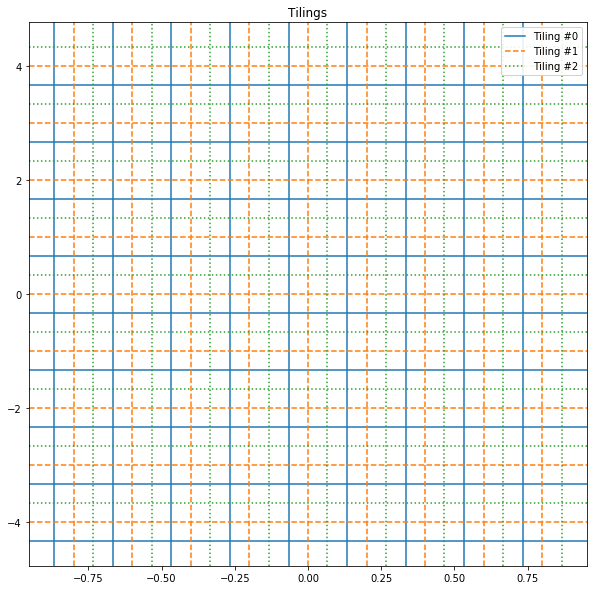

In [43]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyle = ['-', '--',':']
    legend_lines = []
    
    
    fig, ax = plt.subplots(figsize=(10,10))
    for i,grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i%len(colors)], linestyle=linestyle[i%len(linestyle)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color = colors[i%len(colors)], linestyle = linestyle[i%len(linestyle)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))],facecolor='white',framealpha=0.9)
    ax.set_title("Tilings")
    return ax # return Axis object to draw on later, if needed

visualize_tilings(tilings);
            

Great! Now that we have a way to generate these tiling, we can next write our encoding function that will convert any given state value to a discrete vector.

# 4. Tile Encoding 
Implemented the following to produce a vector that contains the indices for each tile that input state value belongs to. The shape of the vector can bet the same as the arrangement of tiles we have, or it can be ultimately flattened for convenience.

We can use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.
    

In [53]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    out = []
        
    return tuple(float(np.digitize(samp,grid[i])) for i,samp in enumerate(sample))

def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    # TODO: Implement this
    #vector = [[] for ii in range(len(tilings))]
    vector = []
    for index,tile in enumerate(tilings):
        temp =discretize(sample,tile)
        vector.append(discretize(sample,tile))
        
    return vector if flatten == False else np.concatenate(vector)


# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")



Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], [(1.0, 8.0), (1.0, 8.0), (0.0, 7.0)], [(2.0, 5.0), (2.0, 5.0), (2.0, 4.0)], [(6.0, 3.0), (6.0, 3.0), (5.0, 2.0)], [(6.0, 3.0), (5.0, 3.0), (5.0, 2.0)], [(9.0, 7.0), (8.0, 7.0), (8.0, 7.0)], [(8.0, 1.0), (8.0, 1.0), (8.0, 0.0)], [(9.0, 9.0), (9.0, 9.0), (9.0, 9.0)]]


In [ ]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing
    print("shape :",samples.shape())
    # Show tiling grids
    ax = visualize_tilings(tilings) 
    
    # If bounds (low,high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0],high[0])
        ax.set_ylim(low[1],high[1])
        
    else:
        # Pre-render (invisible) samples to automatically set reasonable
        ax.plot(samples[:, 0], samples[:,1], 'o',alpha=0.0)

Inspect the results and make sure we understand how the corresponding tiles are being chosen. Note that some samples may have one or more tiles in common.


# 5. Q-Table with Tile Coding

The next step is to design a special Q-tabe that is able to utilize this coding scheme. It should have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it should return a `<value>`. Similarly, it should also allow we to update the `<value >` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to.)

The `<state>` supplied here is assumed to be form the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation when required. 